In [1]:
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify
import orthopy
import scipy
from scipy.special import binom,legendre
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm import tqdm


NameError: name 'optim' is not defined

The notation is completely confused. Let's try to unify it. Consider the method
$$
x_{t+1}=x_t+m_t(x_t-x_{t-1})+h_t\nabla f(x_t)
$$

This leads to the recurrence:
$$
P_{t+1}(\lambda)=a_tP_t(\lambda)+b_t\lambda P_t(\lambda)+(1-a_t)P_{t-1}(\lambda)
$$


Withc $m_t=a_t-1$ and $h_t=b_t$.

The notation used for the monic polynomials in the transforms is:
$$
xP_t(x)=P_{t+1}(x)+\beta_tP_t(x)+\gamma_tP_{t-1}(x)
$$

While the one from Fabian and Damien's is:
$$
Q_t(\lambda)=\lambda Q_{t-1}(\lambda)+\alpha'_tQ_{t-1}(\lambda)+\gamma'_tQ_{t-2}(\lambda)
$$
Thus $(\alpha'_t,\gamma'_t)=-(\beta_t,\gamma_t)$
We'll work with residual notation as in Fabian's and monic as in the transforms paper

In the paper we have the foollowing notations for the Monic Jacobi matrix:
$$
J = \begin{bmatrix} 
    \beta_0 & 1 & 0 &\dots\\
     \gamma_1& \beta_1 &1 &\dots \\
    \vdots &  \gamma_2   &\ddots   & \dots 
    \end{bmatrix}
$$
Which can be $LU$ factorized into:
$$
L = \begin{bmatrix} 
    1 & 0 & \dots\\
     l_1& 1 &0 & \\
    \vdots &  l_2  & \ddots   
    \end{bmatrix} 
$$

$$
U = \begin{bmatrix} 
    u_1 & 0 & \dots\\
     0& u_2 &0  \\
    \vdots &  \ddots  & \ddots   
    \end{bmatrix}
$$

With $l_1=\frac{\gamma_1}{\beta_0}$, $l_n=\frac{\gamma_n}{\beta_{n-1}-l_{n-1}}$ and  $u_0=\beta_0$ $u_n=\beta_n-l_n, n\geq1$. \\
The Darboux transformation (without parameter) can be written:

$$
J^{(p)}_n = \begin{bmatrix} 
   \beta_0+l_1 & 1 & \dots\\
     l_1(\beta_1-l_1)& \beta_1+l_2-l_1 &0  \\
    \vdots &  l_2(\beta_2-l_2)  & \ddots   
    \end{bmatrix}
$$

In [72]:
def darboux(beta,gamma):
    ##we cant compute (J^p)_n with only J_n, we need an extra element of gamma
    ##We that is, we lose one dimension per darboux
    assert len(beta)==len(gamma)
    n=len(beta)
    
    l,nbeta=np.zeros(len(beta)),np.zeros(len(beta))
    l[0]=gamma[0]/beta[0]
    u=[beta[0]]
    for i,g,b in zip(range(1,n),gamma[1:],beta[1:]): l[i]=g/(b-l[i-1])
  
    nbeta[0]=beta[0]+l[0]
    nbeta[1:]=beta[1:]+l[1:]-l[:-1]
    ngamma=l[:-1]*(beta[1:]-l[:-1])
    return nbeta,ngamma

def to_monic(alpha,beta,gamma):
    ##entries as in Apendix B.2 Pedregosa,Scieur
    ##returns beta, gamma as in darboux input
    ##
    assert len(beta)==len(alpha)==len(gamma)+1
    beta2=alpha/beta
    g=gamma/beta[1:]/beta[:-1]
    
    return -beta2,-g
def shift(alpha,beta,a,b):
    ##recurrence coefficients for p_n(x) =u_n(ax+b)
    return alpha*a,beta+a*alpha 
    

def to_residual(alpha,beta,gamma):
    ##entries and returns as in Apendix B.2 Pedregosaur
    assert len(beta)==len(alpha)==len(gamma)+1
    gamma=np.concatenate([np.array([0]),gamma])
    a_ls,b_ls=[],[]
    delta=0
    for alpha_,beta_,gamma_ in zip(alpha,beta,gamma):
        delta=1/(alpha_+gamma_*delta)
        a_ls.append(delta*alpha_)
        b_ls.append(delta*beta_)
        
    return np.array(a_ls),np.array(b_ls)
    
    
def pdarboux(beta,gamma,s):
    u=[s]
    for g,b in zip(gamma,beta): u.append(g/(b-u[-1]))
    u=np.asarray(u)[:,0]
    l=beta-u
    beta2=np.concatenate([np.array([u[0]]),u[1:]+l[:-1]],axis=0)
    return beta2,u*l

def uvarov(gamma,beta,mrfracmu,x):
    b2,g2=darboux(beta-x,gamma)
    s=(beta[0]-x)/(mrfracmu+1)
    b3,g3=pdarboux(b2,g2,s)
    
    return b3+x,g3


def jacobi_momentum(niter=200,b=2,L=4):
    """
    recurrence coefficients for $\lambda^{b+1}d\mu_{MP,L}$
    """
    delta=0
    a_ls,b_ls=[],[]
    for t in range(1,niter+1):
        t2=t**2
        alpha=-(b+2*t)*(2*b**2+4*b*t+b+4*t2-1)
        alpha/=2*t*(b+t+1)*(b+2*t-1)
        
        beta=(b+2*t)*(b+2*t+1)/(L*t*(b+t+1))
        
        gamma=-(t-1/2)*(b+t-1/2)*(b+2*t+1)
        gamma/=t*(b+t+1)*(b+2*t-1)
        
        delta=1/(alpha+gamma*delta)
        
        a,bt=delta*alpha,delta*beta
        a_ls.append(a)
        b_ls.append(bt)
    return np.array(a_ls),np.array(b_ls)

def christoffel(beta,gamma,x0):
    beta-=x0
    beta,gamma=darboux(beta,gamma)
    return beta+x0,gamma


def noisy_jacobi(f=None,L=4,eta=0.1,b=1):
    eta=0.1
    alpha0,beta0=jacobi_momentum(b=b)
    gamma=1-alpha0[1:]
    beta1,gamma1=to_monic(alpha0,beta0,gamma)
    beta1,gamma1=christoffel(beta1[:-1],gamma1,-eta)
    alpha1,gamma1=-beta1,-gamma1 ##change notations
    afinal,bfinal=to_residual(alpha1,np.ones(len(alpha1)),gamma1)
    if f is None:
        return afinal,bfinal
    return fom(f,afinal,bfinal)



In [125]:

def jacobi_w_outlier(f=None,niter=200,b=3,L=4):
    ## wrt $\lambda^bd(\mu_{MP}+\delta_a)$
    n=len(f.x0) if f else 500
    c=1/n
    le_b=b
    if f is not None:
        L=f.L
    a,b=jacobi_momentum(niter+b+1,b=0,L=L)
    beta,gamma=to_monic(a,b,1-a[1:])
    beta,gamma=uvarov(gamma,beta[:-1],c/(1-c),L)
    for _ in range(le_b):
        print(len(beta),len(gamma))
        beta,gamma=darboux(beta,gamma)
        beta=beta[:-1]
    alpha=np.ones(len(beta))
    a,b=to_residual(alpha,-beta,-gamma[:-1])
    if f is None:
        return a,b
    return fom(f,a,b)
a,b=jacobi_w_outlier(b=1)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
##unit test for the transforms
alpha0,beta0=jacobi_momentum(b=1)
gamma=1-alpha0[1:]
beta1,gamma1=to_monic(alpha0,beta0,gamma)
beta1,gamma1=christoffel(beta1[:-1],gamma1,0)
alpha1,gamma1=-beta1,-gamma1 ##change notations
afinal,bfinal=to_residual(alpha1,np.ones(len(alpha1)),gamma1)
a2,b2=jacobi_momentum(b=2)
plt.plot(afinal-a2[:-1])
plt.plot(bfinal-b2[:-1])

In [68]:
ass,bs=noisy_jacobi(L=f.L)

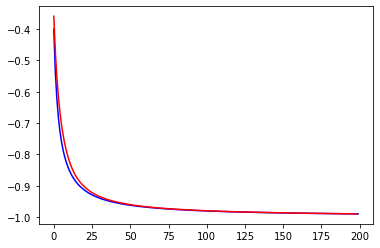

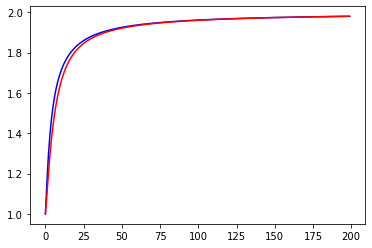

In [76]:
ass,bs=noisy_jacobi(L=f.L,eta=10.0)
jaca,jacb=jacobi_momentum(b=1)
jac2a,jac2b=jacobi_momentum()
plt.plot(jacb,c='b')
plt.plot(bs,c='r')
plt.show()
plt.plot(jaca,c='b')
plt.plot(ass,c='r')



Does jacobi have a limiting method when $\beta\rightarrow\infty$?

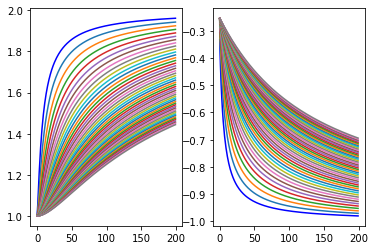

In [5]:
_,(ax1,ax2)=plt.subplots(1,2)
for l in range(3,100,2):
    
    a,b=jacobi_momentum(b=l)
    if l==3:
        ax1.plot(a,c='b')
        ax2.plot(b,c='b')
    else:
        ax1.plot(a)
        ax2.plot(b)

Let  $X\in\mathbb{R}^{N\times n}$, $R=I+\theta uu^T \in \mathbb{R}^{N\times N}$,and $Y=R^{1/2}X$

In [115]:


def fom(f,a_ls,b_ls):
    assert len(b_ls)==len(a_ls)
    x1=x=f.x0
    log=Log()
    log(f,x)
     
    for a,b in zip(a_ls,b_ls):
        
        aux=x
        x=x+(a-1)*(x-x1)+b*f.grad(x)
        x1=aux
        
        log(f,x)
        
    return log,x

def jacobi_method(f,niter=200,b=2,L=4):
    x1=x=f.x0
    afinal,bfinal=jacobi_momentum(niter,b,L)
    return fom(f,afinal,bfinal)


class Log:
    def __init__(self):
        self.log={'grad': [],'x':[],'f':[]}
    def __getitem__(self,k):
        return np.asarray(self.log[k])
    def to_numpy(self):
        a=np.stack(np.asarray(v) for v in self.log.values())
        return a,self.log.keys()
    def __call__(self,f,x): 
        
        self.log['grad'].append(np.linalg.norm(f.grad(x))**2)
        self.log['x'].append(np.linalg.norm(x)**2)
        self.log['f'].append(np.linalg.norm(f(x)**2))
class RandomQuadratic:
    def __init__(self,r=1,sigma=1,n=600,theta=0,eta=0):
        m=int(n*r)
        X=np.random.normal(size=(m,n),scale=sigma)
        R=np.eye(m)
        if theta>0:
            u=np.random.normal(size=(m,1))
            u/=np.linalg.norm(u)
            R+=theta*u@u.T
            R=scipy.linalg.sqrtm(R)
        self.X=1/np.sqrt(n)*(R@X)
        
        self.b=eta*np.random.randn(len(self.X),1)
        
        self.x0=np.random.normal(size=(m,1))
        self.L=scipy.linalg.eigh(self.X.T@self.X,eigvals_only=True,subset_by_index=[m-1,m-1])
        
        
    def plot(self):
        ev,_=np.linalg.eigh(self.A)
        plt.hist(ev[ev<100],bins=30)
        plt.show()
    
    def __call__(self,x):
        return 1/2* np.linalg.norm(self.X@x-self.b)**2

    def grad(self,x):
        return self.X.T@(self.X@x-self.b)
eta=1.0
f=RandomQuadratic(theta=0,eta=eta)
log1,_=noisy_jacobi(f,L=f.L,eta=eta)
log2,_=jacobi_method(f,L=f.L)

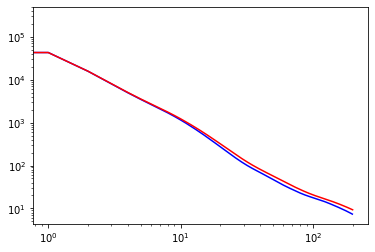

In [116]:
plt.plot(log1['f'],c='b')
plt.plot(log2['f'],c='r')

plt.xscale('log')
plt.yscale('log')

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3856.48it/s]


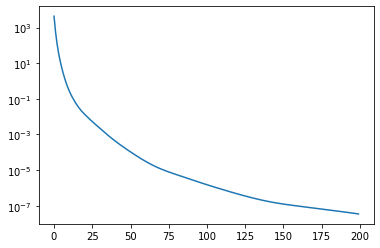

In [98]:
def jake(f,niter=200,b=2,L=4):
    x1=x=f.x0
    delta=0
    log=Log()
    for t in tqdm(range(1,niter+1)):
        t2=t**2
        alpha=-(b+2*t)*(2*b**2+4*b*t+b+4*t2-1)
        alpha/=2*t*(b+t+1)*(b+2*t-1)
        
        beta=(b+2*t)*(b+2*t+1)/(L*t*(b+t+1))
        
        gamma=-(t-1/2)*(b+t-1/2)*(b+2*t+1)
        gamma/=t*(b+t+1)*(b+2*t-1)
        
        delta=1/(alpha+gamma*delta)
        
        a,bt=delta*alpha,delta*beta
        
        aux=x
        x=x+(1-a)*(x1-x)+bt*f.grad(x)
        x1=aux
        
        log(f,x)        
    return log,x

f=RandomQuadratic()
log,_=jake(f,L=f.L)
plt.semilogy(log['f'])


What's the optimal method for $(1-c) \mathcal{MP}(r,\sigma^2) +c\delta_a$?

201 201


<ipython-input-115-de9871e20d0c>:35: RuntimeWarning: overflow encountered in double_scalars
  self.log['f'].append(np.linalg.norm(f(x)**2))


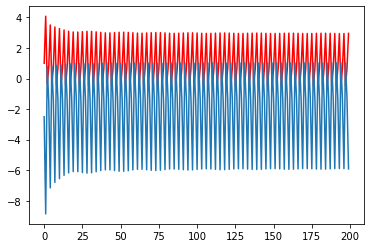

In [120]:

def jacobi_w_outlier(f,niter=200,b=3,L=None):
    ## wrt $\lambda^bd(\mu_{MP}+\delta_a)$
    n=len(f.x0)
    c=1/n
    aux=f.L
    le_b=b
    a,b=jacobi_momentum(niter+b+1,b=0)
    beta,gamma=to_monic(a,b,1-a[1:])
    beta,gamma=uvarov(gamma,beta[:-1],c/(1-c),aux)
    for _ in range(le_b):
        print(len(beta),len(gamma))
        beta,gamma=darboux(beta,gamma)
        beta=beta[:-1]
    alpha=np.ones(len(beta))
    a,b=to_residual(alpha,-beta,-gamma[:-1])
    plt.plot(a,c='r')

    plt.plot(b)
    return fom(f,a,b)
log,_=jacobi_w_outlier(f,b=1)


C:\Users\leona\anaconda3\lib\site-packages\numpy\ma\core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


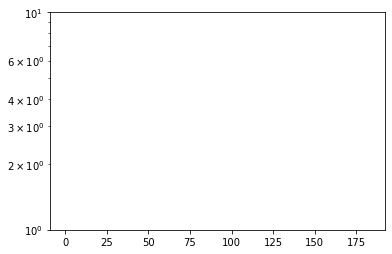

In [121]:
plt.semilogy(log['grad'])

In [ ]:
def mp_moments(rho,sigma2=0.5,N=100): ##wrong recursion
    sigrho=sigma2
    mus=[sigrho]
    for r in range(1,N):
        sigrho*=sigma2*rho
        mus.append(sigma2*r*(r+1)*mus[-1]+sigrho)
        
    return np.asarray(mus)

def _moments(rho,sigma2=0.5,N=100):
    mus=[]
    for r in range(1,N+1):
        sigr=sigma2**r
        mur=0
        for k in range(r):
            mur+=sigr*(rho**k)*binom(r,k)*binom(r-1,k)/(k+1)
        mus.append(mur)
    return np.asarray(mus)
 
_moments(0.5,0.1,200)      
    

In [39]:
m=_moments(0.5,0.1,50)
beta,gamma,_=orthopy.tools.chebyshev(m)
orthopy.tools.gautschi_test_3(m,beta,gamma)

#a1,a2=jacobi_MP(0.5,1,10)
#print(a1,a2)
#print(n1)

C:\Users\leona\anaconda3\lib\site-packages\orthopy\tools\generate_rc.py:174: RuntimeWarning: invalid value encountered in double_scalars
  errors_beta[k] = abs(beta[k] - D[k + 1] * D[k - 1] / D[k] ** 2)
C:\Users\leona\anaconda3\lib\site-packages\orthopy\tools\generate_rc.py:173: RuntimeWarning: invalid value encountered in double_scalars
  errors_alpha[k] = abs(alpha[k] - (Dp[k + 1] / D[k + 1] - Dp[k] / D[k]))


(array([0.00000000e+00, 0.00000000e+00, 2.10942375e-15, 4.08562073e-14,
        3.37174733e-13, 3.18587379e-11, 5.58711077e-10, 4.23371604e-09,
        6.95288228e-07, 3.50820526e-05, 1.36910700e-03, 8.00656185e-02,
        4.78568848e-02, 6.94537927e-02, 3.57274017e-01, 6.90255337e-01,
        1.08781012e+00,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan]),
 array([           nan, 3.46944695e-18, 7.80625564e-18, 8.47412418e-16,
        5.18855792e-15, 3.32543888e-13, 1.07840100e-11, 7.38041329e-11,
        5.77752431e-09, 3.86876977e-07, 1.64961346e-05, 5.85396956e-04,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan]))

In [40]:

N = 10


x = sympy.Symbol("x")
evaluator = orthopy.c1.legendre.Eval(x, "monic")
legendre_polys = [sympy.expand(next(evaluator)) for _ in range(2 * N)]

mod_moments = [sympy.integrate(x ** 2 * poly, (x, -1, +1)) for poly in legendre_polys]
print(mod_moments)
print()

rc = orthopy.c1.legendre.RecurrenceCoefficients("monic", symbolic=True)
alpha, beta, int_1 = orthopy.tools.chebyshev_modified(mod_moments, rc)
print(alpha)
print(beta)

[2/3, 0, 8/45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0 0 0 0 0 0 0 0 0 0]
[nan 3/5 4/35 25/63 16/99 49/143 12/65 27/85 64/323 121/399]


In [81]:
from sympy.abc import rho,x,k
N=30
#evaluator = orthopy.c1.legendre.Eval(x, "monic")
#legendre_polys = [sympy.expand(next(evaluator)) for _ in range(2 * N)]
polys=[legendre(n,True) for n in range(2*N)]
rc = orthopy.c1.legendre.RecurrenceCoefficients("monic", symbolic=False)

w=lambdify([x,rho],sympy.sqrt(1-x**2)/(2*sympy.sqrt(rho)*x+1+rho))
#polys=[lambdify(x,p) for p  in legendre_polys]
mod_moments=np.array([quad((lambda x,a:  p(x)*w(x,a)),-1,1,limit=200,args=0.5)[0] for p in polys])
#mod_moments=np.array()
beta,gamma, _ = orthopy.tools.chebyshev_modified(mod_moments, rc)

##we still have to shift these polynomials


In [86]:
coeffs=[rc[i] for i in range(200)]
alpha,beta,gamma=np.array([c[0] for c in coeffs]),np.array([c[1] for c in coeffs]),np.array([c[2] for c in coeffs])


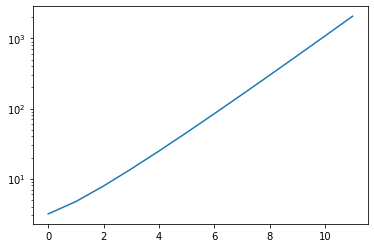

In [44]:
import matplotlib.pyplot as plt
#plt.plot(integs)
plt.semilogy(integs)

In [41]:
from sympy.abc import x,k
integs=[]
for i in range(1,30):
    expr=((1+x)**(i))/sp.sqrt(1-x**2)
    inte=sp.integrals.integrate(expr,(x,-1,1))
    integs.append(float(inte))

KeyboardInterrupt: 

In [39]:
inte.simplify()

63*pi/8

1.4483679868929749


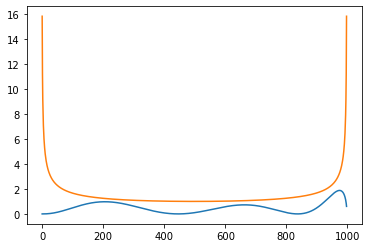

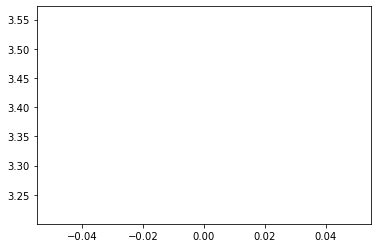

In [1]:
import scipy
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
t=np.linspace(-1,1,1000)
t=t[1:-1]
def jacobi_func(alpha,beta):
    def f(t):
        return ((1-t)**alpha)*((1+t)**beta)
    return f
fdmu= jacobi_func(1/2,5/2)
dmu=fdmu(t)
fs=[]
for n in range(2,3):
    p=scipy.special.jacobi(n,1/2,5/2,False)
    y=p(t)
    ig=(y**2*dmu)
    itl=scipy.integrate.cumtrapz(ig,t)
    print(itl[-1])
    #plt.plot(t[:-1],itl/itl[-1])
    plt.plot((y**2)*dmu/itl[-1])
    aux=1/(np.sqrt(1-t**2))
    plt.plot(aux)
    fs.append(p(-1)**2/itl[-1]**2)
plt.show()
plt.plot(np.log(np.array(fs)))

1.7180584824171259
1.4496118445446726
1.2402234670024987
1.0796588217154253
0.9543412799149205
0.8543784490887532
0.773009072982012
0.7055903839430185
0.6488699448363082
0.6005166556768896
0.5588224423193436
0.5225100713135596
0.490606812150231
0.4623595580680669
0.4371765756021267
0.4145867223944241
0.3942103625854352
0.375738269866962
0.3589160848514665
0.34353270028545263
0.32941146739210725
0.31640345774631595
0.3043822427629113
0.29323980756418616
0.2828833222968047
0.2732325685600649
0.2642178712147463
0.2557784236574318
0.24786092204872834
0.24041844407841362
0.2334095227307775
0.22679737665522745
0.22054926710489917
0.21463595789238485
0.20903125954492183
0.20371164279862597
0.198655909459906
0.19384491088232136
0.1892613062710348
0.18488935437597975
0.18071473332536075
0.17672438424951964
0.17290637513900017
0.16924978191509016
0.1657445842545521
0.16238157406359638
0.1591522748480885
0.1560488705014607
0.15306414224346354
0.15019141265390618
0.14742449586217898
0.144757653170

<ipython-input-12-33d2a94c370b>:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  itl,_=scipy.integrate.quad(f,-1,1)
<ipython-input-12-33d2a94c370b>:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integ

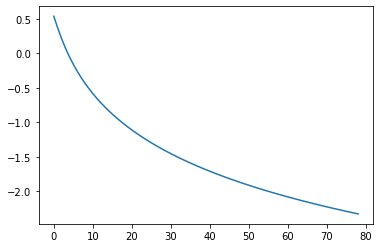

In [12]:
t=np.linspace(-1,1,5000)
t=t[1:-1]
fs=[]
for n in range(1,80):
    p=scipy.special.jacobi(n,1/2,5/2)
    f= lambda x: p(x)**2*fdmu(x)
    itl,_=scipy.integrate.quad(f,-1,1)
    print(itl)
    g=lambda x: f(x)/(1+x)/(itl**2)
    fs.append(scipy.integrate.quad(f,-1,1)[0])
    
#plt.show()
plt.plot(np.log(np.array(fs)))

<ipython-input-14-43c13c67503d>:20: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(a))


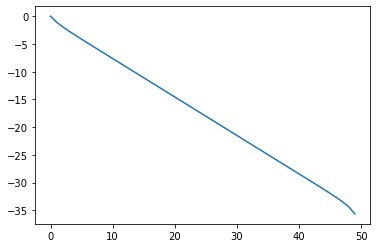

In [14]:

import matplotlib.pyplot as plt 

def mp_rates(sig=1,r=0.5,T=10000):
    rho=(1+r)/np.sqrt(r)
    sum_A=0
    d=-1/rho
    r1=1-1/(sig*(1+r))
    rates=[1,r1]
    A=1.0
    for t in range(2,T):
        d=-1/(rho+d)
        #print(rho,d,-(1+rho*d))
        A*=-(1+rho*d)
        #print(A)
        sum_A+=A
        rates.append(r1+(r1-1)*sum_A)
    return rates
    
a=mp_rates(r=0.5)
plt.plot(np.log(a))     
        